# Implementation of LSTM for news headline generation

In [1]:
# Import necessary modules from Keras for model building
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import keras.utils as ku

# Import TensorFlow and NumPy to set random seed for reproducibility
from tensorflow.random import set_seed
from numpy.random import seed
set_seed(2)  # Set TensorFlow seed
seed(1)      # Set NumPy seed

# Import pandas for data manipulation and numpy for numerical operations
import pandas as pd
import numpy as np
import string, os  # Import string for string operations, os for interacting with the operating system

# Import warnings to suppress warnings
import warnings
warnings.filterwarnings("ignore")  # Ignore all warnings
warnings.simplefilter(action='ignore', category=FutureWarning)  # Specifically ignore FutureWarnings


We start by collecting a bunch of news headlines and cleaning them up by removing any punctuation and converting them to lowercase. Next, we break these headlines down into sequences of words, or tokens, to help our model learn the structure of sentences. We ensure each sequence is the same length by padding them with zeroes at the beginning.   

In [2]:
# Set the directory where the project data files are stored
curr_dir = '/content/drive/MyDrive/Colab Notebooks/ProjectData/'

# Initialize an empty list to store all headlines and all articles dataframe
all_headlines = []
all_articles = []


# Iterate over each file in the specified directory
for filename in os.listdir(curr_dir):
    # Check if the file name contains 'Articles'
    if 'Articles' in filename:
        # Read the CSV file containing articles
        article_df = pd.read_csv(curr_dir + filename)
        all_articles.append(article_df)
        # Extend the all_headlines list with headlines from the dataframe
        all_headlines.extend(list(article_df.headline.values))

# Filter out headlines that are labeled as "Unknown"
all_headlines = [h for h in all_headlines if h != "Unknown"]

articles_df = pd.concat(all_articles, ignore_index=True)

# Print the number of headlines collected
len(all_headlines)


8603

In [3]:
articles_df.head()

,articleID,articleWordCount,byline,documentType,headline,keywords,multimedia,newDesk,printPage,pubDate,sectionName,snippet,source,typeOfMaterial,webURL,abstract
0,5adf6684068401528a2aa69b,781,By JOHN BRANCH,article,Former N.F.L. Cheerleaders’ Settlement Offer: ...,"['Workplace Hazards and Violations', 'Football...",68,Sports,0,2018-04-24 17:16:49,Pro Football,"“I understand that they could meet with us, pa...",The New York Times,News,https://www.nytimes.com/2018/04/24/sports/foot...,NaN
1,5adf653f068401528a2aa697,656,By LISA FRIEDMAN,article,E.P.A. to Unveil a New Rule. Its Effect: Less ...,"['Environmental Protection Agency', 'Pruitt, S...",68,Climate,0,2018-04-24 17:11:21,Unknown,The agency plans to publish a new regulation T...,The New York Times,News,https://www.nytimes.com/2018/04/24/climate/epa...,NaN
2,5adf4626068401528a2aa628,2427,By PETE WELLS,article,"The New Noma, Explained","['Restaurants', 'Noma (Copenhagen, Restaurant)...",66,Dining,0,2018-04-24 14:58:44,Unknown,What’s it like to eat at the second incarnatio...,The New York Times,News,https://www.nytimes.com/2018/04/24/dining/noma...,NaN
3,5adf40d2068401528a2aa619,626,By JULIE HIRSCHFELD DAVIS and PETER BAKER,article,Unknown,"['Macron, Emmanuel (1977- )', 'Trump, Donald J...",68,Washington,0,2018-04-24 14:35:57,Europe,President Trump welcomed President Emmanuel Ma...,The New York Times,News,https://www.nytimes.com/2018/04/24/world/europ...,NaN
4,5adf3d64068401528a2aa60f,815,By IAN AUSTEN and DAN BILEFSKY,article,Unknown,"['Toronto, Ontario, Attack (April, 2018)', 'Mu...",68,Foreign,0,2018-04-24 14:21:21,Canada,"Alek Minassian, 25, a resident of Toronto’s Ri...",The New York Times,News,https://www.nytimes.com/2018/04/24/world/canad...,NaN


In [4]:
print(articles_df.shape)
print(articles_df.info())

(9335, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9335 entries, 0 to 9334
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   articleID         9335 non-null   object
 1   articleWordCount  9335 non-null   int64 
 2   byline            9335 non-null   object
 3   documentType      9335 non-null   object
 4   headline          9335 non-null   object
 5   keywords          9335 non-null   object
 6   multimedia        9335 non-null   int64 
 7   newDesk           9335 non-null   object
 8   printPage         9335 non-null   int64 
 9   pubDate           9335 non-null   object
 10  sectionName       9335 non-null   object
 11  snippet           9335 non-null   object
 12  source            9335 non-null   object
 13  typeOfMaterial    9335 non-null   object
 14  webURL            9335 non-null   object
 15  abstract          167 non-null    object
dtypes: int64(3), object(13)
memory usage: 1.1+ MB
Non

In [5]:
# Define a function to clean text data
def clean_text(txt):
    # Remove punctuation from the text and convert to lowercase
    txt = "".join(v for v in txt if v not in string.punctuation).lower()
    # Encode the text into UTF-8 bytes, then decode back to ASCII, ignoring errors
    txt = txt.encode("utf8").decode("ascii",'ignore')
    # Return the cleaned text
    return txt

# Apply the clean_text function to each headline in the all_headlines list
corpus = [clean_text(x) for x in all_headlines]

# Display the first 10 elements of the corpus
corpus[:10]


['former nfl cheerleaders settlement offer 1 and a meeting with goodell',
 'epa to unveil a new rule its effect less science in policymaking',
 'the new noma explained',
 'how a bag of texas dirt  became a times tradition',
 'is school a place for selfexpression',
 'commuter reprogramming',
 'ford changed leaders looking for a lift its still looking',
 'romney failed to win at utah convention but few believe hes doomed',
 'chain reaction',
 'he forced the vatican to investigate sex abuse now hes meeting with pope francis']

In [6]:
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

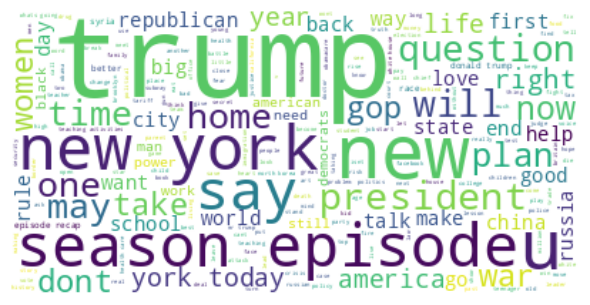

In [7]:
def generate_wordcloud(text, mask=None, max_words=400, max_font_size=120, figure_size=(24.0,16.0),
                       title=None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    additional_words = {'unknown', 'Unknown', 'article'}
    stopwords.update(additional_words)

    # Cleaning to normalize the data
    text = clean_text(text)

    wordcloud = WordCloud(background_color='white',
                          stopwords=stopwords,
                          max_words=max_words,
                          max_font_size=max_font_size,
                          random_state=42,
                          mask=mask)
    wordcloud.generate(text)

    plt.figure(figsize=figure_size)

    if image_color and mask is not None:
        image_colors = ImageColorGenerator(mask)
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
    else:
        plt.imshow(wordcloud, interpolation="bilinear")

    if title:
        plt.title(title, fontdict={'size': title_size, 'color': 'green',
                                  'verticalalignment': 'bottom'})
    plt.axis('off')
    plt.tight_layout()
    plt.show()

headlines = ' '.join(articles_df['headline'].dropna().tolist())
generate_wordcloud(headlines, max_words=500, max_font_size=80, figure_size=(6,4))

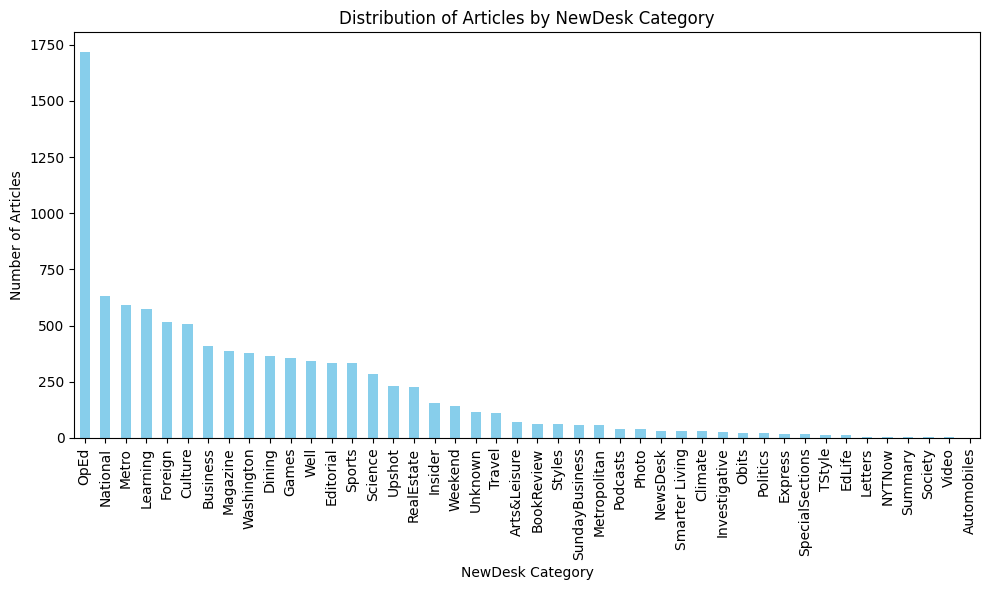

In [8]:
category_counts = articles_df['newDesk'].value_counts()


plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color='skyblue')

# Adding titles and labels
plt.title('Distribution of Articles by NewDesk Category')
plt.xlabel('NewDesk Category')
plt.ylabel('Number of Articles')
plt.xticks(rotation=90)
plt.tight_layout()

# Show the plot
plt.show()


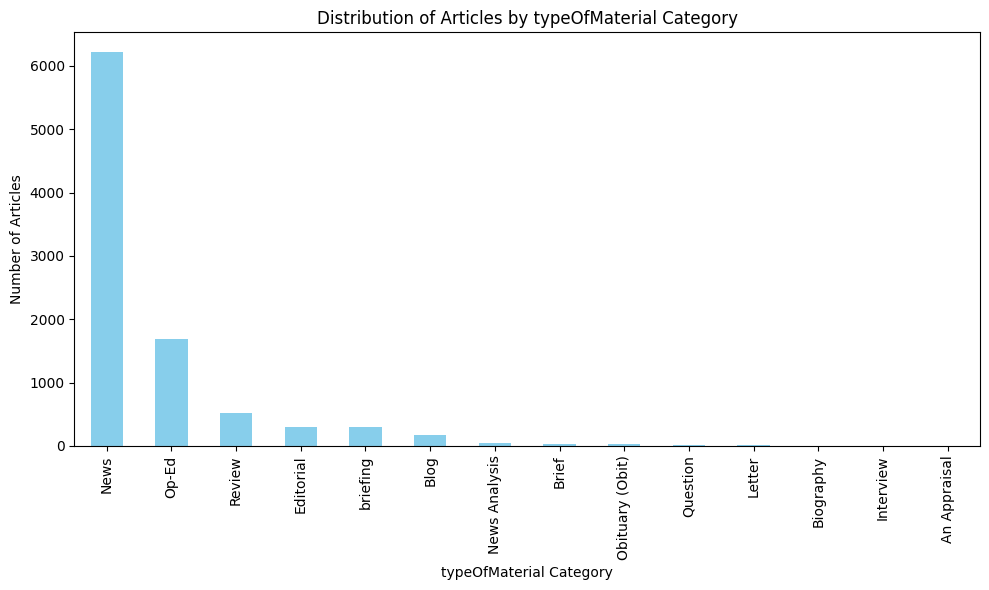

In [9]:
category_counts = articles_df['typeOfMaterial'].value_counts()


plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color='skyblue')

# Adding titles and labels
plt.title('Distribution of Articles by typeOfMaterial Category')
plt.xlabel('typeOfMaterial Category')
plt.ylabel('Number of Articles')
plt.xticks(rotation=90)
plt.tight_layout()

# Show the plot
plt.show()


This script prepares text data for training in a machine learning model, specifically using a 'Tokenizer' from Keras to convert text into numerical sequences. The get_sequence_of_tokens function initializes the Tokenizer on the corpus, assigns a unique numerical identifier to each word, and generates n-grams from each line of text. These n-grams, which are sequences of increasing length, help provide contextual clues that aid the model in predicting the next word. The function returns these sequences along with the total count of unique words.

After transforming the text data into sequences, the generate_padded_sequences function ensures uniformity in sequence length by padding shorter sequences at the beginning. It divides each sequence into predictors (all tokens except the last) and the label (the last token), which the model will attempt to predict. This process also converts the labels into a categorical format, suitable for classification tasks in the model, and records the maximum sequence length.

These steps complete the data preparation, resulting in ready-to-use predictors and labels for model training.

In [10]:
# Importing the required libraries
from sklearn.model_selection import train_test_split

# Split the dataset into train and test sets
train_headlines, test_headlines = train_test_split(corpus, test_size=0.2, random_state=42)

In [11]:
# Import the Tokenizer class from Keras
from keras.preprocessing.text import Tokenizer

# Instantiate a Tokenizer object
tokenizer = Tokenizer()

# Define a function to create sequences of tokens from the corpus
def get_sequence_of_tokens(corpus):
    # Fit the tokenizer on the text data
    tokenizer.fit_on_texts(corpus)
    # Calculate the total number of unique words in the corpus
    total_words = len(tokenizer.word_index) + 1

    # Initialize an empty list to store the sequences of tokens
    input_sequences = []
    # Loop through each line in the corpus
    for line in corpus:
        # Convert the line of text into a list of tokens
        token_list = tokenizer.texts_to_sequences([line])[0]
        # Generate n-gram sequences for each token list
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    # Return the list of input sequences and the total number of words
    return input_sequences, total_words

# Generate input sequences and count total words from the corpus
inp_sequences, total_words = get_sequence_of_tokens(train_headlines)

# Display the first 10 input sequences
inp_sequences[:10]


[[1278, 520],
 [1278, 520, 4375],
 [1278, 520, 4375, 17],
 [1278, 520, 4375, 17, 286],
 [1278, 520, 4375, 17, 286, 5],
 [1278, 520, 4375, 17, 286, 5, 2036],
 [4376, 521],
 [4376, 521, 156],
 [4376, 521, 156, 85],
 [4376, 521, 156, 85, 1620]]

In [12]:
print(len(train_headlines))
print(len(inp_sequences))

6882
41374


In [13]:
# Define a function to generate padded sequences suitable for LSTM input
def generate_padded_sequences(input_sequences):
    # Find the maximum length of sequences in the input data
    max_sequence_len = max([len(x) for x in input_sequences])
    # Pad the sequences so they all have the same length, padding at the beginning ('pre')
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

    # Split the sequences into predictors and the label; predictors are all but the last token
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    # Convert the label to categorical format for use in classification
    label = ku.to_categorical(label, num_classes=total_words)
    # Return the predictors, label, and the maximum sequence length
    return predictors, label, max_sequence_len

# Apply the function to the input sequences to prepare the data for the model
predictors, label, max_sequence_len = generate_padded_sequences(inp_sequences)

In [14]:
print(len(predictors))
print(len(label))

41374
41374


## About the model

Long Short-Term Memory (LSTM) is a type of recurrent neural network (RNN) architecture that is designed to learn order dependence in sequence prediction problems. Unlike standard feedforward neural networks, LSTMs have feedback connections that make them capable of processing sequences of data, allowing them to store, process, and make predictions based on long-term sequential information. This capability is achieved through the use of gates that regulate the flow of information. These gates can learn which data in a sequence is important to keep or throw away, making LSTMs particularly useful for tasks such as speech recognition, language modeling, and time series forecasting.

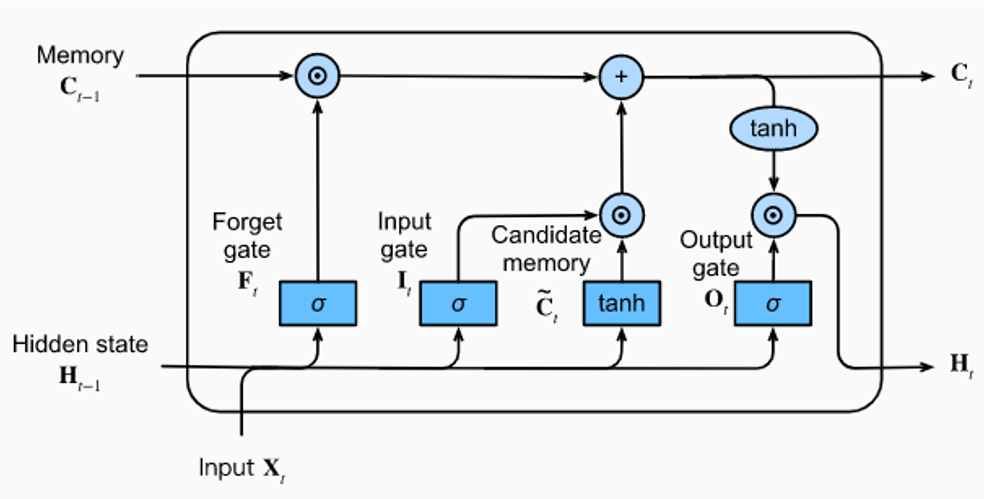

In [15]:
# Import necessary classes and methods for building the model
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

# Define a function to create the LSTM model
def create_model(max_sequence_len, total_words):
    # Calculate input length by subtracting one from the maximum sequence length
    input_len = max_sequence_len - 1
    # Initialize the Sequential model
    model = Sequential()

    # Add an Embedding layer that converts input data into dense vectors of fixed size
    model.add(Embedding(total_words, 10, input_length=input_len))

    # Add an LSTM layer with 100 units
    model.add(LSTM(100))
    # Add a Dropout layer with a dropout rate of 0.1 to prevent overfitting
    model.add(Dropout(0.1))

    # Add a Dense output layer with softmax activation for multi-class classification
    model.add(Dense(total_words, activation='softmax'))

    # Compile the model with categorical crossentropy as the loss function and Adam optimizer
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # Return the constructed model
    return model

# Create an instance of the model using the maximum sequence length and total words
model = create_model(max_sequence_len, total_words)

# Print a summary of the model to view its architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 23, 10)            100160    
                                                                 
 lstm (LSTM)                 (None, 100)               44400     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 10016)             1011616   
                                                                 
Total params: 1156176 (4.41 MB)
Trainable params: 1156176 (4.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
# Train the model on the prepared data
history = model.fit(
    predictors,  # Input features (predictor sequences)
    label,       # Target output (categorical labels)
    epochs=200,  # Number of epochs to train the model
    verbose=1,    # Verbosity mode
    batch_size=64
)

Epoch 1/200
647/647 [==============================] - 22s 28ms/step - loss: 7.8582
Epoch 2/200
647/647 [==============================] - 7s 11ms/step - loss: 7.4419
Epoch 3/200
647/647 [==============================] - 5s 8ms/step - loss: 7.3279
Epoch 4/200
647/647 [==============================] - 6s 10ms/step - loss: 7.1953
Epoch 5/200
647/647 [==============================] - 5s 8ms/step - loss: 7.0404
Epoch 6/200
647/647 [==============================] - 5s 8ms/step - loss: 6.8836
Epoch 7/200
647/647 [==============================] - 5s 8ms/step - loss: 6.7272
Epoch 8/200
647/647 [==============================] - 5s 7ms/step - loss: 6.5637
Epoch 9/200
647/647 [==============================] - 6s 9ms/step - loss: 6.3991
Epoch 10/200
647/647 [==============================] - 5s 7ms/step - loss: 6.2313
Epoch 11/200
647/647 [==============================] - 4s 7ms/step - loss: 6.0657
Epoch 12/200
647/647 [==============================] - 6s 9ms/step - loss: 5.9084
Epoch 13/

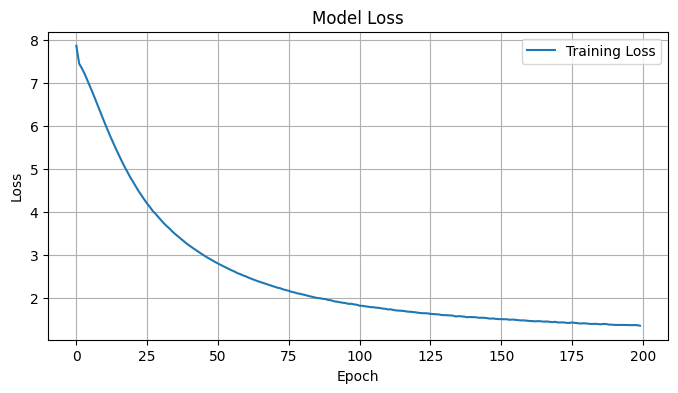

In [17]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

After the model is trained, we can use it to generate new text. We give it a starting piece of text, known as 'seed text,' and it generates the next word. We add this word to our text and ask it to predict the next one, and so on, for as many words as we want. This way, the model helps us create new sentences that are similar in style to the news headlines it trained on.

In [18]:
# Import numpy for numerical operations
import numpy as np

# Define a function to generate text based on a seed text and a model
def generate_text(seed_text, next_words, model, max_sequence_len):
    # Loop over the number of words to be generated
    for _ in range(next_words):
        # Convert the current seed text to a sequence of tokens
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        # Pad the token list to ensure it has the required length for the model input
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        # Predict the probability distribution of the next word
        predicted_probs = model.predict(token_list, verbose=0)
        # Select the token with the highest probability as the next word
        predicted = np.argmax(predicted_probs, axis=-1)[0]

        # Initialize an empty string for the output word
        output_word = ""
        # Iterate over the word_index to find the word corresponding to the predicted index
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        # Append the predicted word to the seed text
        seed_text += " " + output_word
    # Return the generated text with each word capitalized
    return seed_text.title()

In [19]:
print(generate_text("USA", 7, model, max_sequence_len))
print(generate_text("Black History month", 7, model, max_sequence_len))
print(generate_text("Donald Trump master", 3, model, max_sequence_len))
print(generate_text("Racing cars", 7, model, max_sequence_len))
print(generate_text("Minimum wage workers protest the", 3, model, max_sequence_len))
print(generate_text("Protest errupt", 10, model, max_sequence_len))
print(generate_text("North Korea", 6, model, max_sequence_len))

Usa Gymnastics Still Values Medals More Than Girls
Black History Month Pressing Forward On The Heels Of Progress
Donald Trump Master Of Low Expectations
Racing Cars Decline In Value Why To Be Moved
Minimum Wage Workers Protest The Justice Of Reform
Protest Errupt At Sacramento City Hall As Speakers Condemn Killing By Police
North Korea Said To Hold Us Citizen Its


In [21]:
import math

reference_headlines = [headline.split() for headline in test_headlines]
generated_headlines = []
for headline in test_headlines:
  length = len(headline.split())
  seed_words_length = math.ceil(length * 0.3)
  generated_headlines.append(generate_text(" ".join(headline.lower().split()[:seed_words_length]), length - seed_words_length, model, max_sequence_len).lower())

In [22]:
for i in range(10):
  print(" ".join(reference_headlines[i]))
  print(generated_headlines[i])
  print()

the dows record rise sends a former wall street stock broker back in time
the dows record rise sends fight about you at the lives of work say

trump jumps in trying to propel health care bill
trump jumps in the job of a bar and

believe it or not a fifa plan that could benefit the game
believe it or not a small crisis on trying to keep governor

haunting news on trump and russia
haunting news has look for a

teaching activities for north korea is willing to talk with us souths leader says
teaching activities for north korea syrian toll of director scandal close in india control

cereal upstart snares a spot in city schools
cereal upstart snares a spot in city schools

regional dishes worth an early trip
regional dishes the 10th inning with

a performer whos not just body and snarl
a performer whos looks with the winter palace

fashion comebacks
fashion are

a swift success marred by scandal
a swift disputed embassy in a



In [23]:
from nltk.translate.bleu_score import corpus_bleu

bleu_score = corpus_bleu(reference_headlines, generated_headlines)
print("BLEU Score:", bleu_score)

BLEU Score: 0.2651331066389661
